[Leveraging ESG Data to Operationalize Sustainability. November 11, 2020. Antoine Amend. Databricks](https://www.databricks.com/blog/2020/11/11/leveraging-esg-data-to-operationalize-sustainability.html)

https://www.databricks.com/notebooks/esgops_notebooks/01_vessel_etl.html

In [0]:
dbutils.fs.mkdirs("/nga")

Out[67]: True

In [0]:
%sh
cd /dbfs/nga
curl -o UpdatedPub150.csv "https://msi.nga.mil/api/publications/download?type=view&key=16920959/SFH00000/UpdatedPub150.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3183k    0 3183k    0     0  5135k      0 --:--:-- --:--:-- --:--:-- 5126k


In [0]:
%sh
ls /dbfs/nga

UpdatedPub150.csv


In [0]:
%sh
head -n 1 /dbfs/nga/UpdatedPub150.csv

World Port Index Number,Region Name,Main Port Name,Alternate Port Name,UN/LOCODE,Country Code,World Water Body,IHO S-130 Sea Area,Sailing Direction or Publication,Publication Link,Standard Nautical Chart,IHO S-57 Electronic Navigational Chart,IHO S-101 Electronic Navigational Chart,Digital Nautical Chart,Tidal Range (m),Entrance Width (m),Channel Depth (m),Anchorage Depth (m),Cargo Pier Depth (m),Oil Terminal Depth (m),Liquified Natural Gas Terminal Depth (m),Maximum Vessel Length (m),Maximum Vessel Beam (m),Maximum Vessel Draft (m),Offshore Maximum Vessel Length (m),Offshore Maximum Vessel Beam (m),Offshore Maximum Vessel Draft (m),Harbor Size,Harbor Type,Harbor Use,Shelter Afforded,Entrance Restriction - Tide,Entrance Restriction - Heavy Swell,Entrance Restriction - Ice,Entrance Restriction - Other,Overhead Limits,Underkeel Clearance Management System,Good Holding Ground,Turning Area,Port Security,Estimated Time of Arrival Message,Quarantine - Pratique,Quarantine - Sanitation,Quarant

In [0]:
dbutils.fs.cp("/nga/UpdatedPub150.csv", "dbfs:/FileStore/tables/UpdatedPub150.csv")

Out[71]: True

In [0]:
%scala
import org.apache.spark.sql.functions._
import org.apache.spark.sql.types.IntegerType

// Define the path to the CSV files
val path = "dbfs:/FileStore/tables/UpdatedPub150.csv"

// Read the CSV files into a DataFrame
val df = spark.read.format("csv")
  .option("header", "true")
  .option("inferSchema", "true")
  .load(path)

// Replace invalid characters in column names with underscores
val newCols = df.columns.map(_.replaceAll("[ ,;{}()\n\t=]", "_"))
val dfRenamed = df.toDF(newCols: _*)

// Convert the World_Port_Index_Number column to integer and fail if it's not possible
val dfWithIntegerColumn = dfRenamed.withColumn("World_Port_Index_Number", $"World_Port_Index_Number".cast(IntegerType).as("World_Port_Index_Number"))
  .na.drop("all", Seq("World_Port_Index_Number"))

// Add a new column for the file name
val dfWithFileName = dfWithIntegerColumn.withColumn("filename", input_file_name())

// Drop the existing table if it exists
spark.sql("DROP TABLE IF EXISTS ais.UpdatedPub150")

// Write the DataFrame to the Delta table
dfWithFileName.write.format("delta")
  .mode("overwrite") // Overwrite the existing table
  .saveAsTable("ais.UpdatedPub150")

import org.apache.spark.sql.functions._
import org.apache.spark.sql.types.IntegerType
path: String = dbfs:/FileStore/tables/UpdatedPub150.csv
df: org.apache.spark.sql.DataFrame = [World Port Index Number: double, Region Name: string ... 106 more fields]
newCols: Array[String] = Array(World_Port_Index_Number, Region_Name, Main_Port_Name, Alternate_Port_Name, UN/LOCODE, Country_Code, World_Water_Body, IHO_S-130_Sea_Area, Sailing_Direction_or_Publication, Publication_Link, Standard_Nautical_Chart, IHO_S-57_Electronic_Navigational_Chart, IHO_S-101_Electronic_Navigational_Chart, Digital_Nautical_Chart, Tidal_Range__m_, Entrance_Width__m_, Channel_Depth__m_, Anchorage_Depth__m_, Cargo_Pier_Depth__m_, Oil_Terminal_Depth__m_, Liquified_Natural_Gas_Terminal_Depth__m_, Maximum_Vessel_Length__m_, Maximum_Vessel_Beam__m_, Maximum_Vessel_Draft__m_, Offshore_Maximum_Vessel_Length__m_, Offshore_Maximum_Vessel_Beam__m_, Offshore_Maximum_Vessel_Draft__m_, Harbor_Size, Harbor_Type, Harbor_Use, Shelter_Afforded, Entrance_Restriction_-_Tide, Entrance_Restriction_-_Heavy_Swell, Entrance_Restriction_-_Ice, Entrance_Restriction_-_Other, Overhead_Limits, Underkeel_Clearance_Management_System, Good_Holding_Ground, Turning_Area, Port_Security, Estimated_Time_of_Arrival_Message, Quarantine_-_Pratique, Quarantine_-_Sanitation, Quarantine_-_Other, Traffic_Separation_Scheme, Vessel_Traffic_Service, First_Port_of_Entry, US_Representative, Pilotage_-_Compulsory, Pilotage_-_Available, Pilotage_-_Local_Assistance, Pilotage_-_Advisable, Tugs_-_Salvage, Tugs_-_Assistance, Communications_-_Telephone, Communications_-_Telefax, Communications_-_Radio, Communications_-_Radiotelephone, Communications_-_Airport, Communications_-_Rail, Search_and_Rescue, NAVAREA, Facilities_-_Wharves, Facilities_-_Anchorage, Facilities_-_Dangerous_Cargo_Anchorage, Facilities_-_Med_Mooring, Facilities_-_Beach_Mooring, Facilities_-_Ice_Mooring, Facilities_-_Ro-Ro, Facilities_-_Solid_Bulk, Facilities_-_Liquid_Bulk, Facilities_-_Container, Facilities_-_Breakbulk, Facilities_-_Oil_Terminal, Facilities_-_LNG_Terminal, Facilities_-_Other, Medical_Facilities, Garbage_Disposal, Chemical_Holding_Tank_Disposal, Degaussing, Dirty_Ballast_Disposal, Cranes_-_Fixed, Cranes_-_Mobile, Cranes_-_Floating, Cranes_-_Container, Lifts_-_100+_Tons, Lifts_-_50-100_Tons, Lifts_-_25-49_Tons, Lifts_-_0-24_Tons, Services_-_Longshoremen, Services_-_Electricity, Services_-_Steam, Services_-_Navigation_Equipment, Services_-_Electrical_Repair, Services_-_Ice_Breaking, Services_-_Diving, Supplies_-_Provisions, Supplies_-_Potable_Water, Supplies_-_Fuel_Oil, Supplies_-_Diesel_Oil, Supplies_-_Aviation_Fuel, Supplies_-_Deck, Supplies_-_Engine, Repairs, Dry_Dock, Railway, Latitude, Longitude)
dfRenamed: org.apache.spark.sql.DataFrame = [World_Port_Index_Number: double, Region_Name: string ... 106 more fields]
dfWithIntegerColumn: org.apache.spark.sql.DataFrame = [World_Port_Index_Number: int, Region_Name: string ... 106 more fields]
dfWithFileName: org.apache.spark.sql.DataFrame = [World_Port_Index_Number: int, Region_Name: string ... 107 more fields]

In [0]:
df_UpdatedPub150 = spark.read.table("ais.UpdatedPub150")

In [0]:
df_UpdatedPub150.printSchema()

root
 |-- World_Port_Index_Number: integer (nullable = true)
 |-- Region_Name: string (nullable = true)
 |-- Main_Port_Name: string (nullable = true)
 |-- Alternate_Port_Name: string (nullable = true)
 |-- UN/LOCODE: string (nullable = true)
 |-- Country_Code: string (nullable = true)
 |-- World_Water_Body: string (nullable = true)
 |-- IHO_S-130_Sea_Area: string (nullable = true)
 |-- Sailing_Direction_or_Publication: string (nullable = true)
 |-- Publication_Link: string (nullable = true)
 |-- Standard_Nautical_Chart: string (nullable = true)
 |-- IHO_S-57_Electronic_Navigational_Chart: string (nullable = true)
 |-- IHO_S-101_Electronic_Navigational_Chart: string (nullable = true)
 |-- Digital_Nautical_Chart: string (nullable = true)
 |-- Tidal_Range__m_: double (nullable = true)
 |-- Entrance_Width__m_: double (nullable = true)
 |-- Channel_Depth__m_: double (nullable = true)
 |-- Anchorage_Depth__m_: double (nullable = true)
 |-- Cargo_Pier_Depth__m_: double (nullable = true)
 |-- 

In [0]:
df_UpdatedPub150.count()

Out[74]: 3739

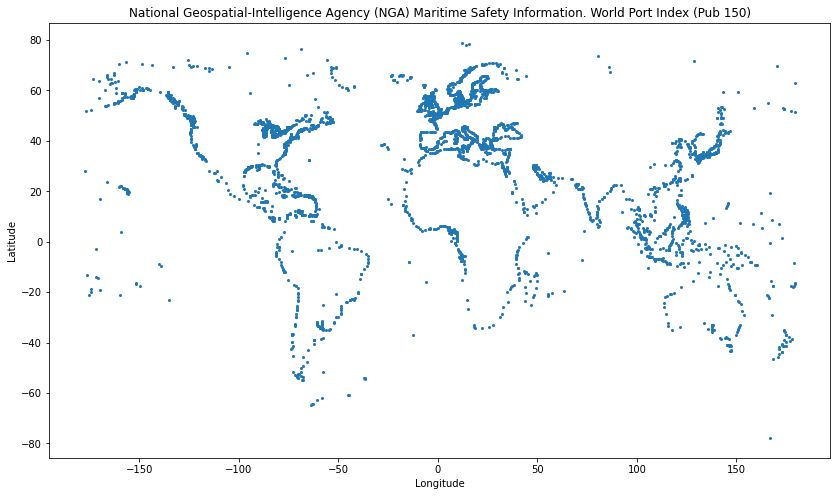

In [0]:
import numpy as np
import matplotlib.pyplot as plt

#spark dataframe to use
df_spark_to_use = df_UpdatedPub150

# Convert the Spark DataFrame to a pandas DataFrame
df_pandas = df_spark_to_use.toPandas()
 
# Set the figure size
fig, ax = plt.subplots(figsize=(14, 8))
 
# Create a scatter plot using matplotlib
ax.scatter(df_pandas["Longitude"], df_pandas["Latitude"], s=4)
 
# Set the plot title and axis labels
ax.set_title("National Geospatial-Intelligence Agency (NGA) Maritime Safety Information. World Port Index (Pub 150)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
 
# Show the plot
plt.show()

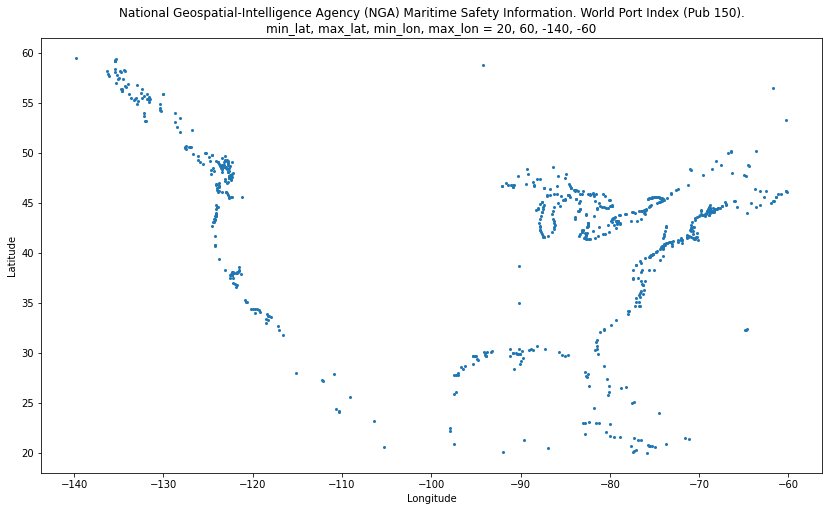

In [0]:
import numpy as np
import matplotlib.pyplot as plt

#spark dataframe to use
df_spark_to_use = df_UpdatedPub150

# Specify the bounding box
min_lat, max_lat, min_lon, max_lon = 20, 60, -140, -60
 
# Filter the data to only include points within the bounding box
df_filtered = df_spark_to_use.filter((df_spark_to_use["Latitude"] >= min_lat) & (df_spark_to_use["Latitude"] <= max_lat) & \
                        (df_spark_to_use["Longitude"] >= min_lon) & (df_spark_to_use["Longitude"] <= max_lon))
 
# Convert the Spark DataFrame to a pandas DataFrame
df_pandas = df_filtered.toPandas()
 
# Set the figure size
fig, ax = plt.subplots(figsize=(14, 8))
 
# Create a scatter plot using matplotlib
ax.scatter(df_pandas["Longitude"], df_pandas["Latitude"], s=4)
 
# Set the plot title and axis labels
ax.set_title("National Geospatial-Intelligence Agency (NGA) Maritime Safety Information. World Port Index (Pub 150).\nmin_lat, max_lat, min_lon, max_lon = 20, 60, -140, -60")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
 
# Show the plot
plt.show()

In [0]:
df_US = df_UpdatedPub150[df_UpdatedPub150['Country_Code'] == 'United States']

In [0]:
# Save the DataFrame to the Delta Lake table location
df_US.write.format("delta").mode("overwrite").save("dbfs:/mnt/delta-lake/ais/UpdatedPub150_US")
 
# Register the table in the Spark catalog
spark.sql("CREATE TABLE ais.UpdatedPub150_US USING delta LOCATION 'dbfs:/mnt/delta-lake/ais/UpdatedPub150_US'")

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
<command-97616581672699> in <cell line: 5>()
      3 
      4 # Register the table in the Spark catalog
----> 5 spark.sql("CREATE TABLE ais.UpdatedPub150_US USING delta LOCATION 'dbfs:/mnt/delta-lake/ais/UpdatedPub150_US'")

/databricks/spark/python/pyspark/instrumentation_utils.py in wrapper(*args, **kwargs)
     46             start = time.perf_counter()
     47             try:
---> 48                 res = func(*args, **kwargs)
     49                 logger.log_success(
     50                     module_name, class_name, function_name, time.perf_counter() - start, signature

/databricks/spark/python/pyspark/sql/session.py in sql(self, sqlQuery, **kwargs)
   1117             sqlQuery = formatter.format(sqlQuery, **kwargs)
   1118         try:
-> 1119             return DataFrame(self._jsparkSession.sql(sqlQuery), self)
   1120     

In [0]:
df_UpdatedPub150_US = spark.read.table("ais.UpdatedPub150_US")

In [0]:
df_UpdatedPub150_US.printSchema()

root
 |-- World_Port_Index_Number: integer (nullable = true)
 |-- Region_Name: string (nullable = true)
 |-- Main_Port_Name: string (nullable = true)
 |-- Alternate_Port_Name: string (nullable = true)
 |-- UN/LOCODE: string (nullable = true)
 |-- Country_Code: string (nullable = true)
 |-- World_Water_Body: string (nullable = true)
 |-- IHO_S-130_Sea_Area: string (nullable = true)
 |-- Sailing_Direction_or_Publication: string (nullable = true)
 |-- Publication_Link: string (nullable = true)
 |-- Standard_Nautical_Chart: string (nullable = true)
 |-- IHO_S-57_Electronic_Navigational_Chart: string (nullable = true)
 |-- IHO_S-101_Electronic_Navigational_Chart: string (nullable = true)
 |-- Digital_Nautical_Chart: string (nullable = true)
 |-- Tidal_Range__m_: double (nullable = true)
 |-- Entrance_Width__m_: double (nullable = true)
 |-- Channel_Depth__m_: double (nullable = true)
 |-- Anchorage_Depth__m_: double (nullable = true)
 |-- Cargo_Pier_Depth__m_: double (nullable = true)
 |-- 

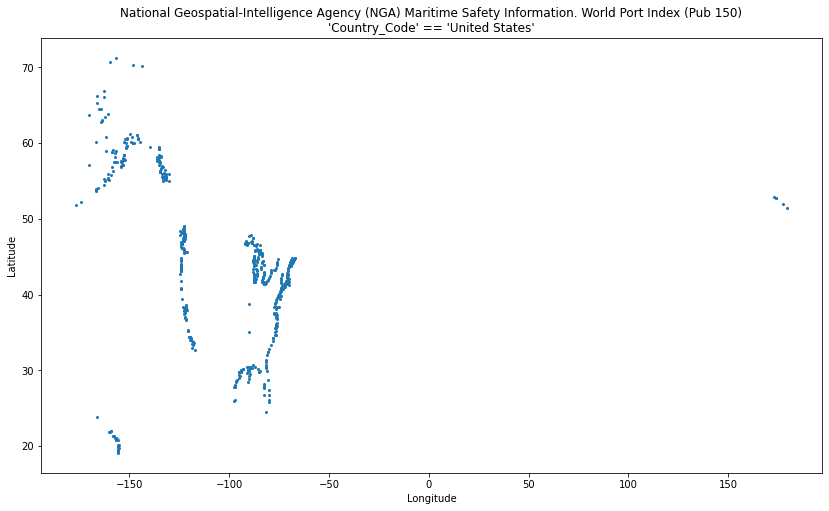

In [0]:
import numpy as np
import matplotlib.pyplot as plt

#spark dataframe to use
df_spark_to_use = df_UpdatedPub150_US

# Convert the Spark DataFrame to a pandas DataFrame
df_pandas = df_spark_to_use.toPandas()
 
# Set the figure size
fig, ax = plt.subplots(figsize=(14, 8))
 
# Create a scatter plot using matplotlib
ax.scatter(df_pandas["Longitude"], df_pandas["Latitude"], s=4)
 
# Set the plot title and axis labels
ax.set_title("National Geospatial-Intelligence Agency (NGA) Maritime Safety Information. World Port Index (Pub 150)\n'Country_Code' == 'United States'")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
 
# Show the plot
plt.show()

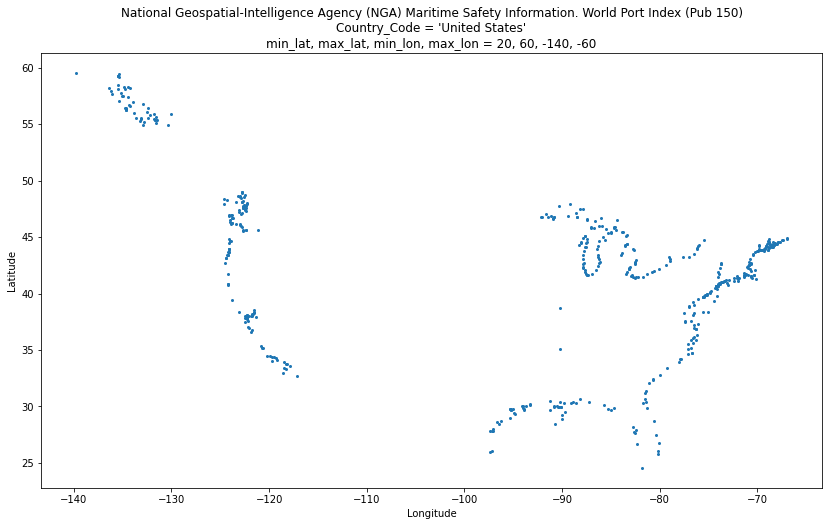

In [0]:
import numpy as np
import matplotlib.pyplot as plt

#spark dataframe to use
df_spark_to_use = df_UpdatedPub150_US

# Specify the bounding box
min_lat, max_lat, min_lon, max_lon = 20, 60, -140, -60
 
# Filter the data to only include points within the bounding box
df_filtered = df_spark_to_use.filter((df_spark_to_use["Latitude"] >= min_lat) & (df_spark_to_use["Latitude"] <= max_lat) & \
                        (df_spark_to_use["Longitude"] >= min_lon) & (df_spark_to_use["Longitude"] <= max_lon))
 
# Convert the Spark DataFrame to a pandas DataFrame
df_pandas = df_filtered.toPandas()
 
# Set the figure size
fig, ax = plt.subplots(figsize=(14, 8))
 
# Create a scatter plot using matplotlib
ax.scatter(df_pandas["Longitude"], df_pandas["Latitude"], s=4)
 
# Set the plot title and axis labels
ax.set_title("National Geospatial-Intelligence Agency (NGA) Maritime Safety Information. World Port Index (Pub 150)\nCountry_Code = 'United States'\nmin_lat, max_lat, min_lon, max_lon = 20, 60, -140, -60")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
 
# Show the plot
plt.show()

In [0]:
df_Oil_Terminal_Depth_gt_0 = spark.read.table("ais.UpdatedPub150") \
    .filter("Oil_Terminal_Depth__m_ > 0")

In [0]:
df_Oil_Terminal_Depth_gt_0.count()

Out[42]: 1688

In [0]:
# Save the DataFrame to the Delta Lake table location
df_Oil_Terminal_Depth_gt_0.write.format("delta").mode("overwrite").save("dbfs:/mnt/delta-lake/ais/UpdatedPub150_Oil_Terminal_Depth_gt_0")

# Register the table in the Spark catalog
spark.sql("CREATE TABLE ais.UpdatedPub150_Oil_Terminal_Depth_gt_0 USING delta LOCATION 'dbfs:/mnt/delta-lake/ais/UpdatedPub150_Oil_Terminal_Depth_gt_0'")

Out[86]: DataFrame[]

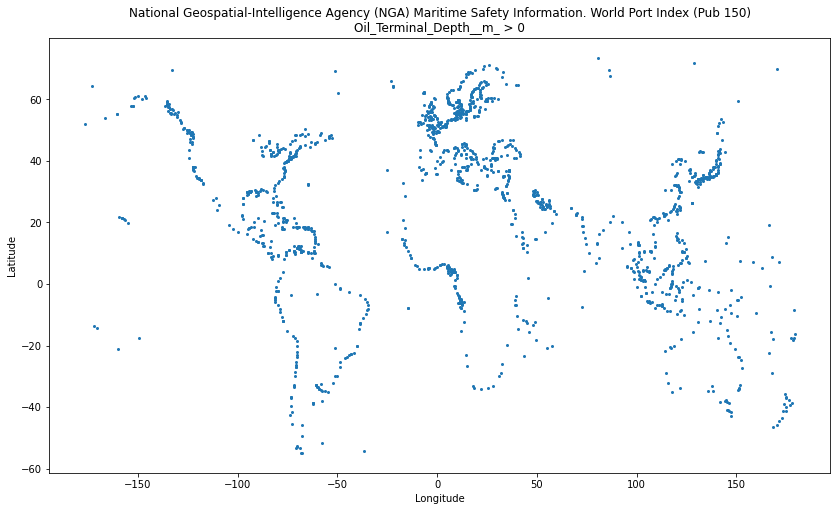

In [0]:
import numpy as np
import matplotlib.pyplot as plt

#spark dataframe to use
df_spark_to_use = df_Oil_Terminal_Depth_gt_0

# Convert the Spark DataFrame to a pandas DataFrame
df_pandas = df_spark_to_use.toPandas()
 
# Set the figure size
fig, ax = plt.subplots(figsize=(14, 8))
 
# Create a scatter plot using matplotlib
ax.scatter(df_pandas["Longitude"], df_pandas["Latitude"], s=4)
 
# Set the plot title and axis labels
ax.set_title("National Geospatial-Intelligence Agency (NGA) Maritime Safety Information. World Port Index (Pub 150)\nOil_Terminal_Depth__m_ > 0")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
 
# Show the plot
plt.show()

In [0]:
df_UpdatedPub150_Oil_Terminal_Depth_gt_0_US = spark.sql("""
    SELECT * 
    FROM ais.UpdatedPub150_US
    INTERSECT
    SELECT *
    FROM ais.UpdatedPub150_Oil_Terminal_Depth_gt_0
""")


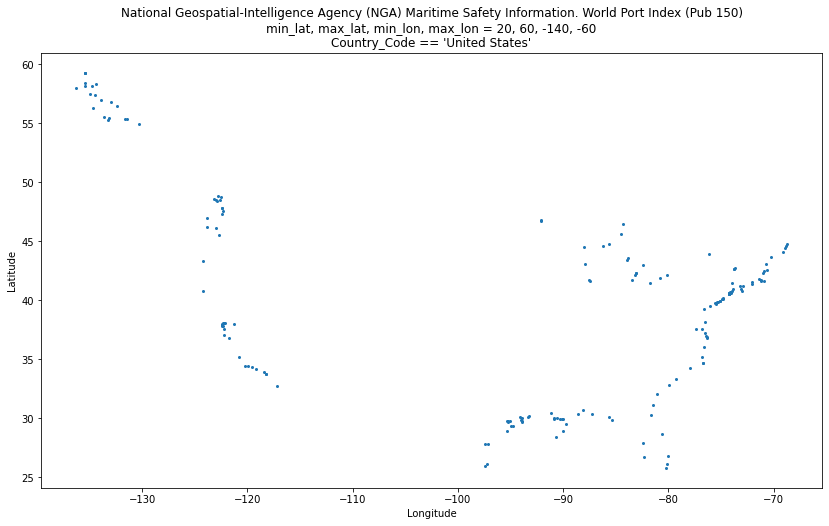

In [0]:
import numpy as np
import matplotlib.pyplot as plt

#spark dataframe to use
df_spark_to_use = df_UpdatedPub150_Oil_Terminal_Depth_gt_0_US

# Specify the bounding box
min_lat, max_lat, min_lon, max_lon = 20, 60, -140, -60
 
# Filter the data to only include points within the bounding box
df_filtered = df_spark_to_use.filter((df_spark_to_use["Latitude"] >= min_lat) & (df_spark_to_use["Latitude"] <= max_lat) & \
                        (df_spark_to_use["Longitude"] >= min_lon) & (df_spark_to_use["Longitude"] <= max_lon))
 
# Convert the Spark DataFrame to a pandas DataFrame
df_pandas = df_filtered.toPandas()
 
# Set the figure size
fig, ax = plt.subplots(figsize=(14, 8))
 
# Create a scatter plot using matplotlib
ax.scatter(df_pandas["Longitude"], df_pandas["Latitude"], s=4)
 
# Set the plot title and axis labels
ax.set_title("National Geospatial-Intelligence Agency (NGA) Maritime Safety Information. World Port Index (Pub 150)\nmin_lat, max_lat, min_lon, max_lon = 20, 60, -140, -60\nCountry_Code == 'United States'")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
 
# Show the plot
plt.show()